In [2]:
import os
import numpy as np
import pandas as pd
import nltk
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import networkx as nx

In [3]:
def importFile(path):
    content = []
    with open(path) as f:
        content = f.readlines()
    
    info = content[:3]
    content = content[3::]
    for i, line in enumerate(content):
        content[i] = nltk.RegexpTokenizer(r"\w+").tokenize(line)
    info[-1] = nltk.RegexpTokenizer(r"\w+").tokenize(info[-1])
    
    df = pd.DataFrame(content[1::], columns = content[0])
    df["FromNodeId"] = df["FromNodeId"].map(int)
    df["ToNodeId"] = df["ToNodeId"].map(int)
    
    return info, df

In [4]:
def createGraph(content):
    G = nx.from_pandas_edgelist(content,source = "FromNodeId", target = "ToNodeId")
    return G.to_directed()

In [5]:
def PageRank(G, d = 0.85, max_iters = 100):
    n = G.number_of_nodes()
    rank = {}
    node_val = {}
    error = []
    for node in G.nodes():
        rank[node] = 1/n
        node_val[node] = 0
        
    for _ in range(max_iters):            
        for node in G.nodes():
            out = G.out_edges(node)
            n_edges = len(out)
            for edge in out:
                node_val[edge[1]] += rank[edge[0]]/n_edges

        for node in G.nodes():
            node_val[node] = (1-d)/n + d*node_val[node]
        
        e = mse(list(rank.values()),list(node_val.values()))
        error.append(e)
        
        for node in G.nodes():
            rank[node] = node_val[node]
            node_val[node] = 0
        
        if e < 1e-15:
            break
        
    return error, rank

In [6]:
def updation(G, a, b, norm, type_):
    for node in G.nodes():
        if type_ == "authority":
            edges = G.in_edges(node)
        else:
            edges = G.out_edges(node)
        n_edges = len(edges)
        a[node] = 0
        for edge in edges:
            if type_ == "authority":
                a[node] += b[edge[0]]
            else:
                a[node] += b[edge[1]]
                
        norm += a[node]**2
    norm = np.sqrt(norm)
    for node in G.nodes():
        a[node] /= norm
        
def HITS(G, max_iters = 100):
    n = G.number_of_nodes()
    hub = {}
    authority = {}
    e1 = []
    e2 = []
    
    for node in G.nodes():
        hub[node] = 1
        authority[node] = 1
    
    cur_auth = authority.copy()
    cur_hub = hub.copy()
    
    for _ in range(max_iters):
        updation(G,authority,hub,0,"authority")
        updation(G,hub,authority,0,"hub")
        
        e1.append(mse(list(authority.values()),list(cur_auth.values())))
        e2.append(mse(list(hub.values()),list(cur_hub.values())))

        cur_auth = authority.copy()
        cur_hub = hub.copy()
        
        if e1[-1] < 1e-20 and e2[-1] < 1e-20:
            break
            
    return authority, hub, e1[1::], e2[1::]

In [7]:
def sortDict(d, title):
    d = {key : value for key, value in sorted(d.items(), key=lambda item: item[1], reverse = True)}
    i = 0
    print("top 10 " + title + " scores :")
    for key, val in d.items():
        if i<10:
            print(key,"\t",val)
        i+=1
    print()
    return d

In [8]:
path = "dataset/Wiki-Vote.txt"
meta, content = importFile(path)
G = createGraph(content)

In [9]:
error, rank = PageRank(G)

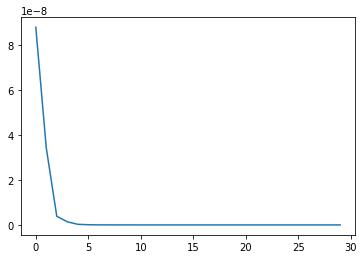

In [10]:
plt.plot(error)

In [11]:
authority, hub, e1, e2 = HITS(G)

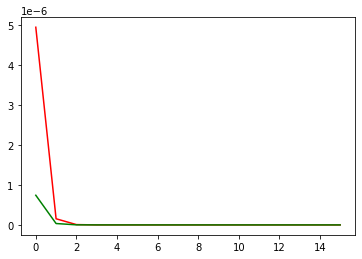

In [12]:
plt.plot(e1,'r',e2, 'g')

In [13]:
rank = sortDict(rank, "rank")
authority = sortDict(authority, "authority")
hub = sortDict(hub, "hub")

top 10 rank scores :
2565 	 0.0043372949187308815
11 	 0.003017206269367328
766 	 0.002968177479349323
457 	 0.002963411320667381
4037 	 0.002878218886740526
1549 	 0.0028581648714845506
1166 	 0.002669208905008099
2688 	 0.0023843472728713416
15 	 0.002163159726354969
1374 	 0.002131987766043142

top 10 authority scores :
2565 	 0.15769611748358103
766 	 0.13015243025685455
1549 	 0.12938941353080033
1166 	 0.11950594168986171
2688 	 0.11008403659853248
457 	 0.10999186611635883
3352 	 0.09179709631226124
11 	 0.08956574261869124
1151 	 0.08717924518500951
1374 	 0.08692950770481205

top 10 hub scores :
2565 	 0.157696117537377
766 	 0.13015243029945367
1549 	 0.12938941344572305
1166 	 0.11950594165584667
2688 	 0.11008403661789759
457 	 0.10999186615700852
3352 	 0.09179709627666102
11 	 0.08956574247014454
1151 	 0.08717924513642718
1374 	 0.08692950771109112



In [14]:
meta

['# Directed graph (each unordered pair of nodes is saved once): Wiki-Vote.txt \n',
 '# Wikipedia voting on promotion to administratorship (till January 2008). Directed edge A->B means user A voted on B becoming Wikipedia administrator.\n',
 ['Nodes', '7115', 'Edges', '103689']]